In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import cv2 as cv
import torch
import numpy as np

## Guess silouette
In this section I want to find a method to determine the silouette of object

In [2]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

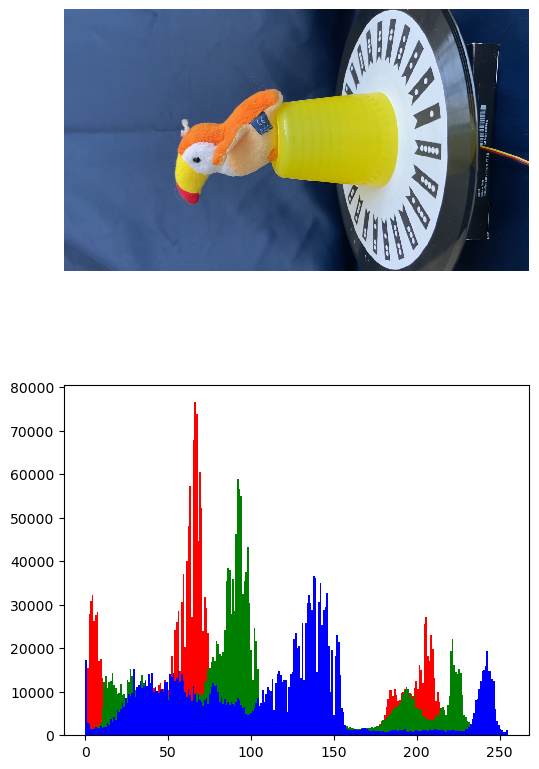

In [3]:
frame_id = 230
video = cv.VideoCapture(FOLDER + VIDEO)
video.set(cv.CAP_PROP_POS_FRAMES, frame_id)
ret, I = video.read()
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
I_gray = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sb.set_theme(style="whitegrid", rc=custom_params)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
# plt.figure(figsize=(10, 4))
axs[0].imshow(I, interpolation="none")
axs[0].axis('off')
axs[1].hist(I[:, :, 0].ravel(), 256, color="red")
axs[1].hist(I[:, :, 1].ravel(), 256, color="green")
axs[1].hist(I[:, :, 2].ravel(), 256, color="blue")
print("")

### Sharpening using Laplacian filter

(-0.5, 1919.5, 1079.5, -0.5)

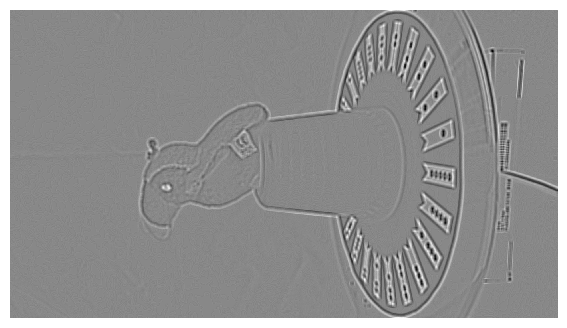

In [178]:
I_l = cv.GaussianBlur(I, (15, 15), 5)
I_l = cv.cvtColor(I_l, cv.COLOR_RGB2GRAY)
I_l = cv.Laplacian(I_l, cv.CV_16S, ksize=7)
plt.figure(figsize=(10, 4))
plt.imshow(I_l, interpolation="none",cmap = 'gray')
plt.axis('off')

### Unsharp

(-0.5, 1919.5, 1079.5, -0.5)

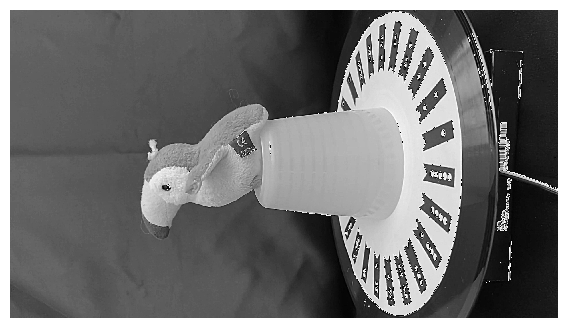

In [139]:
I_g = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
I_us = I_g - cv.GaussianBlur(I_g, (15, 15), 3)

plt.figure(figsize=(10, 4))
plt.imshow(I_g + I_us, interpolation="none", cmap = 'gray')
plt.axis('off')

### Bilateral filter

(-0.5, 1919.5, 1079.5, -0.5)

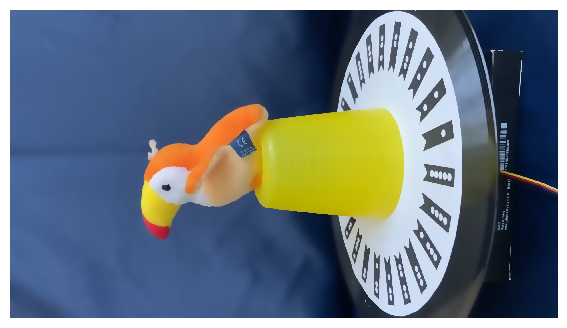

In [114]:
I_b = cv.bilateralFilter(I, 30, 75, 75)
plt.figure(figsize=(10, 4))
plt.imshow(I_b, interpolation="none")
plt.axis('off')

### Equalize colors

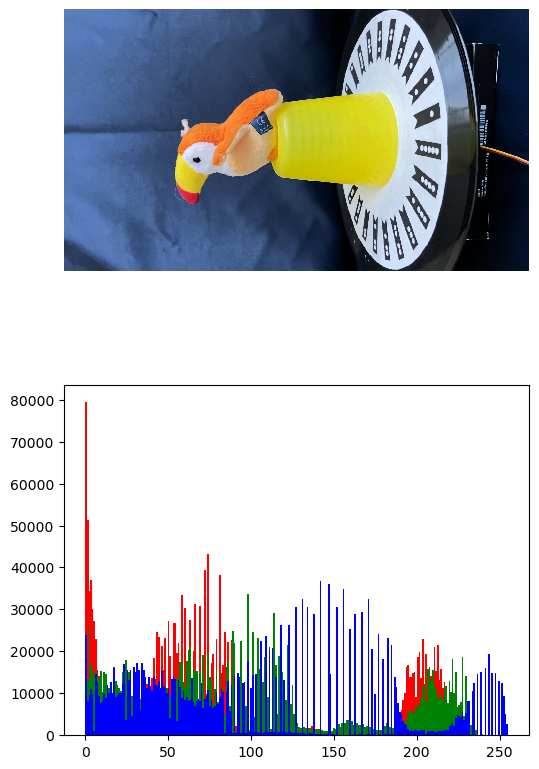

<Figure size 1000x400 with 0 Axes>

In [97]:
I_hsi = cv.cvtColor(I, cv.COLOR_RGB2HSV)
# equalize intensity of brightness
I_e = cv.equalizeHist(I_hsi[:, :, 2])
I_hsi[:, :, 2] = I_e
# change saturation
I_hsi[:, :, 0] += 0
I_hsi = cv.cvtColor(I_hsi, cv.COLOR_HSV2RGB)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
plt.figure(figsize=(10, 4))
axs[0].imshow(I_hsi, interpolation="none")
axs[0].axis('off')
axs[1].hist(I_hsi[:, :, 0].ravel(), 256, color="red")
axs[1].hist(I_hsi[:, :, 1].ravel(), 256, color="green")
axs[1].hist(I_hsi[:, :, 2].ravel(), 256, color="blue")
print("")

## Gamma correction (Work)
Being that this approach works I decided to define a decision area in YUV space using the norm 2 and the infinite norm.
From that I discovered that Euclidean distance works better.

In [5]:
def gammaCorrection(I, G=1.):
    invG = 1/G
    table = [((i/255)**invG)*255 for i in range(256)]
    # color map
    table = np.array(table, np.uint8)
    # apply color map
    return cv.LUT(I, table)

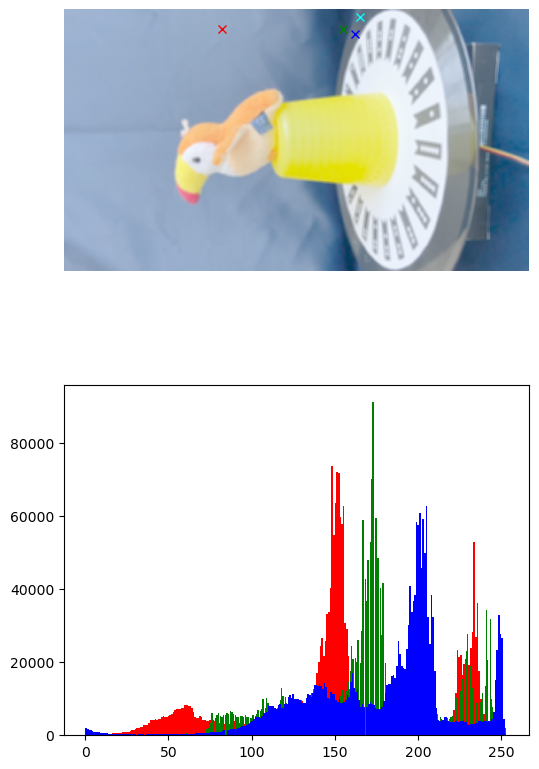

<Figure size 1000x400 with 0 Axes>

In [93]:
I_gc = gammaCorrection(I, G=2.6)
I_gc = cv.blur(I_gc, (15, 15))
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
plt.figure(figsize=(10, 4))
axs[0].imshow(I_gc, interpolation="none")
axs[0].plot(650, 80, marker="x", color="red")
axs[0].plot(1200, 100, marker="x", color="blue")
axs[0].plot(1220, 30, marker="x", color="cyan")
axs[0].plot(1150, 80, marker="x", color="green")
axs[0].axis('off')
axs[1].hist(I_gc[:, :, 0].ravel(), 256, color="red")
axs[1].hist(I_gc[:, :, 1].ravel(), 256, color="green")
axs[1].hist(I_gc[:, :, 2].ravel(), 256, color="blue")
print("")

In [94]:
# convert from RGB to YUV space color
I_yuv = cv.cvtColor(I_gc, cv.COLOR_RGB2YUV)
# Normalize UV channels between [-0.5 ... 0.5]
UV = I_yuv[:,:,1:3] / 255.0 - 0.5  

In [70]:
UV[80, 650] # background

array([ 0.06078431, -0.06078431])

In [71]:
UV[80, 1150] # background

array([ 0.08039216, -0.09215686])

In [72]:
UV[100, 1200] # foreground

array([ 0.02941176, -0.0254902 ])

In [73]:
UV[30, 1220] # foreground

array([ 0.04509804, -0.04901961])

In [7]:
# Euclidean distance for standardized color coordinate in YUV color space
def chroma_distance_ED(UV, u, v):
    return np.sqrt((UV[:,:,0] - u)**2 + (UV[:,:,1] - v)**2)

# compute infinity norm with a modified origin defined by (u, v)
def chroma_norm_L_inf(UV, u, v):
    # modify origin in coordinate (u, v)
    UV[:,:,0] = np.abs(UV[:,:,0] - u)    
    UV[:,:,1] = np.abs(UV[:,:,1] - v)
    # compute infinity norm
    t = torch.max(torch.Tensor(UV), dim=2)
    return np.array(t[0])

# create mask for standardized color coordinate in YUV color space
def create_mask(UV_image, u_center, v_center, max_dist_foreground, f_distance, foreground_from_x=None):
    # mask composes only by ones
    mask = np.ones(UV.shape[:2])
    if foreground_from_x is None:
        # create mask
        mask = f_distance(UV_image, u_center, v_center) > max_dist_foreground  
    else:
        # create mask
        mask[:, :(foreground_from_x + 1)] = f_distance(UV_image[:, :(foreground_from_x + 1), :], u_center, v_center) > max_dist_foreground
    return mask

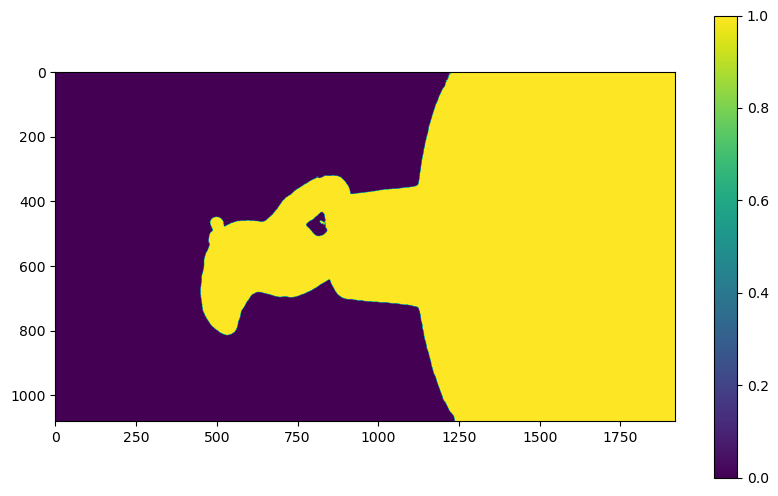

In [95]:
# convert from RGB to YUV space color
I_yuv = cv.cvtColor(I_gc, cv.COLOR_RGB2YUV)
# Normalize UV channels between [-0.5 ... 0.5]
UV = I_yuv[:,:,1:3] / 255.0 - 0.5  
# mask = create_mask(UV, 0.275, -0.275, 0.226, chroma_norm_L_inf, 1300)
mask = create_mask(UV, 0.275, -0.275, 0.31819805, chroma_distance_ED, 1300)
plt.figure(figsize=(10, 6))
plt.imshow(mask)
plt.colorbar()

#### Rejection area for euclidean distance

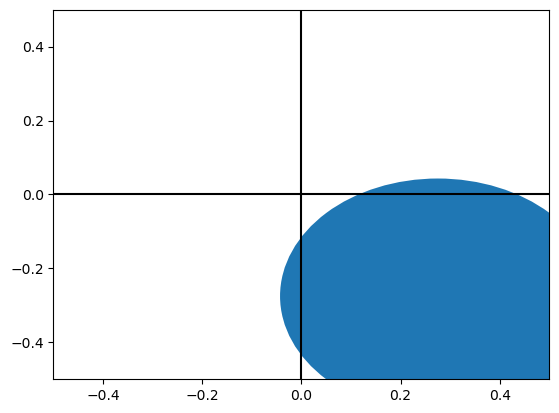

In [115]:
figure, axes = plt.subplots()
plt.ylim(bottom=-.5, top=.5)
plt.xlim(left=-.5, right=.5)
Drawing_colored_circle = plt.Circle(( 0.275, -0.275 ), 0.31819805)
plt.plot([-2, -1, 0, 1, 2], [0, 0, 0, 0, 0], color="black")
plt.plot([0, 0, 0, 0, 0], [-2, -1, 0, 1, 2], color="black")

axes.add_artist(Drawing_colored_circle)

### Opening and Closing
This morphological operations are useful to remove fill the blank inside the tucan.
After this test I noticed that is better if I use only the closing operation since that with opening I need a bigger kernel to close the hole.

In [162]:
M = mask
kernel_O = np.ones((3,3), np.uint8)

kernel_C = np.ones((47,47), np.uint8)

M = cv.morphologyEx(M, cv.MORPH_OPEN, kernel_O)
M = cv.morphologyEx(M, cv.MORPH_CLOSE, kernel_C)

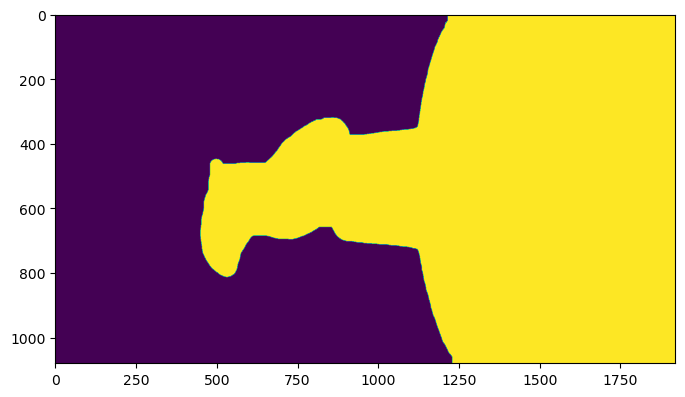

In [164]:
plt.figure(figsize=(8, 6))
plt.imshow(M)

### Change color
Define the region where I can set as foreground

In [115]:
def changeColor(I, color:np.array, f):
    I_c = np.copy(I)
    I_c[:, f:, ::] = color
    return I_c

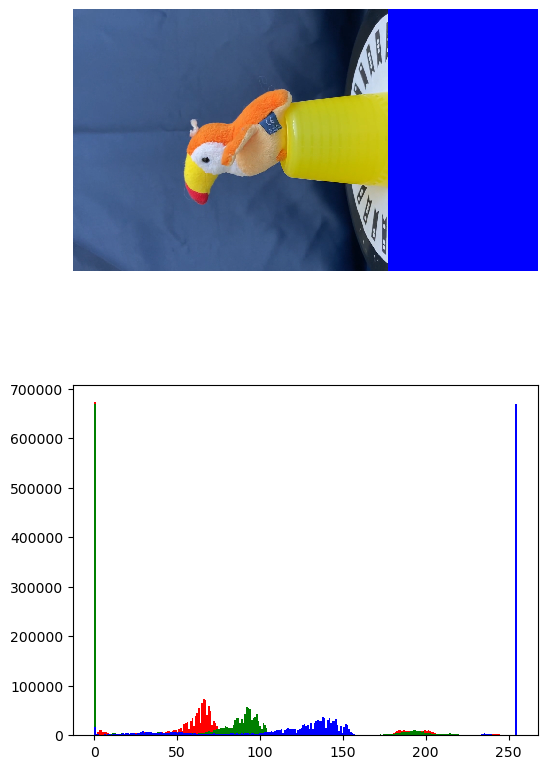

<Figure size 1000x400 with 0 Axes>

In [116]:
I_c = changeColor(I, np.array([0, 0, 255]), 1300)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
plt.figure(figsize=(10, 4))
axs[0].imshow(I_c, interpolation="none")
axs[0].axis('off')
axs[1].hist(I_c[:, :, 0].ravel(), 256, color="red")
axs[1].hist(I_c[:, :, 1].ravel(), 256, color="green")
axs[1].hist(I_c[:, :, 2].ravel(), 256, color="blue")
print("")

## Code for assignment

In [2]:
# correction of gamma
def gammaCorrection(I, G=1.):
    invG = 1/G
    table = [((i/255)**invG)*255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv.LUT(I, table)

# Euclidean distance for standardized color coordinate in YUV color space
def chroma_distance_ED(UV, u, v):
    return np.sqrt((UV[:,:,0] - u)**2 + (UV[:,:,1] - v)**2)

# create mask for standardized color coordinate in YUV color space
def create_mask(UV_image, u_center, v_center, max_dist_foreground, f_distance, foreground_from_x=None, background_to_x=None):
    if foreground_from_x is None:
        foreground_from_x = UV_image.shape[1]
    if background_to_x is None:
        background_to_x = 0
    # mask composes only by ones
    mask = np.ones(UV.shape[:2])        
    # create mask
    mask[:, :(foreground_from_x + 1)] = f_distance(UV_image[:, :(foreground_from_x + 1), :], u_center, v_center) > max_dist_foreground
    # add constant background
    mask[:, 0:(background_to_x + 1)] = 0
    return mask   

In [4]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

In [ ]:
video = cv.VideoCapture(FOLDER + VIDEO)
frame_id = 200
total_frames = video.get(cv.CAP_PROP_FRAME_COUNT)
while True:
    video.set(cv.CAP_PROP_POS_FRAMES, frame_id)
    # read new frame
    ret, I_origin = video.read()
    # clear plot of previous frame
    display.clear_output(wait=True)
    # used to solve problem of darkness
    I = gammaCorrection(I_origin, G=2.5)
    # used to solve problem of hairs on object
    I = cv.blur(I, (15, 15))
    # convert from BGR to YUV space color
    I_yuv = cv.cvtColor(I, cv.COLOR_BGR2YUV)
    # Normalize UV channels between [-0.5; 0.5]
    UV = I_yuv[:,:,1:3] / 255.0 - 0.5 
    # create mask
    mask = create_mask(UV, 0.275, -0.275, 0.31819805, chroma_distance_ED, 1300, 400)
    # apply closing
    if N_V == 1:
        # kernel for closing
        kernel_C = np.ones((47, 47), np.uint8)
        # I don't apply opening otherwise the hole will re open and to use both open and close
        # I should increase the kernel size of closing, and this brings me to a worse silouette
        # apply closing to close the hole
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel_C)
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    axs[0].axis("off")
    # plot figure 1
    axs[0].imshow(mask, interpolation="none")
    axs[1].axis("off")
    # plot figure 2
    axs[1].imshow(cv.cvtColor(I_origin, cv.COLOR_BGR2RGB), interpolation="none")
    # get current figure and display it
    display.display(plt.gcf())
    # change frame
    frame_id += 5
    
    # rule to exit
    if frame_id > total_frames:
        break
video.release()